In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [9]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3, dirichlet, neumann

In [2]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [3]:
def f(x,y):
    return 1

In [4]:
def ud(x,y):
    return 0

In [41]:
from numpy import zeros


def boucle_triangle(nt, elements3, coordinates, A, B) :
    for n in range(nt):
        i = elements3[n][0]
        j = elements3[n][1]
        k = elements3[n][2]
        striangle = [i, j, k]
        xg = (coordinates[i][0] + coordinates[j][0] + coordinates[k][0])/3
        yg = (coordinates[i][1] + coordinates[j][1] + coordinates[k][1])/3

        a = [[(coordinates[j][0]- coordinates[i][0]), (coordinates[k][0]-coordinates[i][0])], [(coordinates[j][1]- coordinates[i][1]), (coordinates[k][1]-coordinates[i][1])]]
        alpha = np.linalg.det(a)

        T = abs(alpha/2)
        M = zeros((3,3))
        bth = zeros((3,1))
        for a in range(len(M)) :
            for b in range(len(M)) :
                n_eta_a = zeros((2,1))
                n_eta_b = zeros((2,1))
                n_eta_a[0] = (1/alpha)*(coordinates [striangle[(a+1)%3]] [1] - coordinates [striangle[(a+2)%3]] [1])
                n_eta_a[1] = (1/alpha)*(coordinates [striangle[(a+2)%3]] [0] - coordinates [striangle[(a+1)%3]] [0])
                n_eta_b[0] = (1/alpha)*(coordinates [striangle[(b+1)%3]] [1] - coordinates [striangle[(b+2)%3]] [1])
                n_eta_b[1] = (1/alpha)*(coordinates [striangle[(b+2)%3]] [0] - coordinates [striangle[(b+1)%3]] [0])
                M[a][b] = T*np.matmul(np.transpose(n_eta_a),n_eta_b)
            bth[a] = (alpha/6)*f(xg,yg)
        ### Assemblage de la Matrice dans le cas d'un maillage constitué uniquement d'éléments triangles ###
        for c in range(len(M)) :
            for d in range(len(M)) :
                A[elements3[n][c]] [elements3[n][d]] += M[c][d] 
            B[elements3[n][c]] = bth[c]
    return A,B

[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
[[ 1.  -0.5 -0.5]
 [-0.5  0.5  0. ]
 [-0.5  0.   0.5]]
A : 

[[ 1

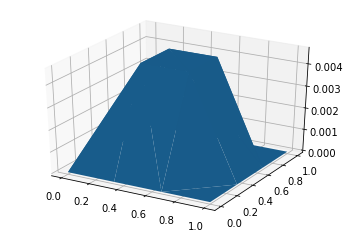

In [44]:
from numpy import ones, zeros, transpose

[coordinates, elements3, dirichlet, neumann] = maillage(4)
ns = len(coordinates)       #nb de sommets
nt = len(elements3)        #nb de triangles
A = zeros((ns, ns))
B = zeros((ns, 1))


### Construction de la Matrice de raideur élémentaire M ###

### Construction de la Matrice de raideur élémentaire M ###
[A,B] =  boucle_triangle(nt, elements3, coordinates, A, B)

    
### Assemblage du second membre ###
# Dirichlet non homogène
uh = zeros((ns, 1))
for i in dirichlet :
    m = ud(coordinates[i][0][0],coordinates[i][0][1])
    uh[i] = m
B = B - np.dot(A,uh)
# Recherche des sommets
u = uh
iterdif = np.setdiff1d(range(ns), dirichlet)
for i in iterdif :
    u[i] = B[i]/A[i][i]
    

## TEST
print("A : \n")
print(A)
print("b : \n")
print(B)
print("u : \n")
print(u)
show(coordinates,u[:,0])

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [ ]:
def fq (quad, coordinates) :
    a = 0
    b = 0
    c = 0
    return a,b,c

In [ ]:
from numpy import zeros


def boucle_quadrangle(nq, elements4, coordinates,A,B) :
    for n in range(nt):
        i = elements4[n][0]
        j = elements4[n][1]
        k = elements4[n][2]
        l = elements4[n][3]
        squadrangle = [i, j, k, l]
        a,b,c = fq(squadrangle, coordinates)
        xg = (coordinates[i][0] + coordinates[j][0] + coordinates[k][0] + coordinates[l][0])/4
        yg = (coordinates[i][1] + coordinates[j][1] + coordinates[k][1] + coordinates[l][1])/4

        a = [[(coordinates[j][0] - coordinates[i][0]), (coordinates[k][0]-coordinates[i][0])],
         [(coordinates[j][1] - coordinates[i][1]), (coordinates[k][1]-coordinates[i][1])]]
        alpha = np.linalg.det(a)

        T = alpha/2
        M = zeros((4, 4))
        bth = zeros((4, 1))
        for a in range(len(M)):
            for b in range(len(M)):
                n_eta_a = zeros((2, 1))
                n_eta_b = zeros((2, 1))
                n_eta_a[0] = (1/alpha)*(coordinates[(a+1) % 3]
                                    [1]-coordinates[(a+2) % 3][1])
                n_eta_a[1] = (1/alpha)*(coordinates[(a+2) % 3]
                                    [0]-coordinates[(a+1) % 3][0])
                n_eta_b[0] = (1/alpha)*(coordinates[(b+1) % 3]
                                    [1]-coordinates[(b+2) % 3][1])
                n_eta_b[1] = (1/alpha)*(coordinates[(b+2) % 3]
                                    [0]-coordinates[(b+1) % 3][0])
                M[a][b] = T*np.dot(np.transpose(n_eta_a), n_eta_b)
            bth[a] = (alpha/4)*f(xg, yg)

        ### Assemblage de la Matrice dans le cas d'un maillage constitué uniquement d'éléments triangles ###
        for c in range(len(M)):
            for d in range(len(M)):
                A[elements3[n][c]][elements3[n][d]] += M[c][d]
            B[elements3[n][c]] = sum(bth)
            
    return A,B

In [ ]:
############################# Maillage mixte ################
elements3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
elements4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dirichlet=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
coordinates=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

ns = len(coordinates)      #nb de sommets
nt = len(elements3)        #nb de triangles
nq = len(elements4)        #nb de quadrangles
A = zeros((ns, ns))
B = zeros((ns, 1))


### Boucle sur les Triangles ###
[A, B] = boucle_triangle(nt, elements3,coordinates, A, B)


### Boucle sur les Quadrangle ###
[A, B] = boucle_quadrangle(nq, elements4, coordinates, A, B) 


### Assemblage du second membre ###
# Dirichlet non homogène
uh = zeros((ns, 1))
for i in dirichlet :
    m = ud(coordinates[i][0][0],coordinates[i][0][1])
    uh[i] = m
B = B - np.dot(A,uh)
# Recherche des sommets
u = uh
iterdif = np.setdiff1d(range(ns), dirichlet)
for i in iterdif :
    u[i] = B[i]/A[i][i]
    

## TEST
print("A : \n")
print(A)
print("b : \n")
print(B)
print("u : \n")
print(u)
show(coordinates,u[:,0])

**Compléments  :  un nouveau terme dans l'EDP**